<div style="text-align: center; font-family: Arial">
    <h1 style="color: #2c3e50">Final Project</h1>
    <h2 style="color: #34495e">7957 - DATA MINING & MACHINE LEARNING</h2>
    <h3 style="color: #7f8c8d">Thibaud Fievet</h3>
    <hr style="width: 50%; border: 1px solid #bdc3c7;">
</div>

# Descriptive Analysis

The selected Taiwanese Bankruptcy Predictions dataset is suitable for this project because:

1 - First, it fulfills the structural, size requirements:

a) Instances: The dataset contains 6,819 instances > 5,000

b) Features: It includes 95 features > 15

2 - Most importantly, it is ideal for two out of 3 machine learning tasks:

a) For Classification: The dataset's primary value lies in its explicit binary target variable ('y'), which indicates whether a company went bankrupt.

b) For Clustering: The high dimensionality provides a rich dataset for unsupervised learning. By applying clustering algorithms  to these features, we can explore whether distinct, naturally occurring "profiles" of companies (for example 'financially stable', 'at-risk' or 'high-growth/high-debt') exist within the data, independent of the final bankruptcy label.

First let's import libraries and load the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

In [2]:
try:
    df = pd.read_csv('data.csv')
    print("Dataset loaded succesfuly. Number of instances  :", len(df))
except FileNotFoundError:
    print("Error : File 'data.csv' not find.")
    df = pd.DataFrame() 

print(df.head())

Dataset loaded succesfuly. Number of instances  : 6819
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295

There's a little space at the beginning of each title of features, we will remove them in order to avoid any future mistake.

We also noticed that there's 1 constant columnso we will get rid of her. 

There's also another column that has only 8 out of 6819 "1" value (0.11%). We can clearly consider that this is a near-zero variance predictor 
so will remove her too

In [3]:
print("Columns before cleanning :")
print(df.columns[:5])
df.columns = df.columns.str.strip()

print("Columns after cleanning :")
print(df.columns[:5])

unique_counts = df.nunique()

constant_cols = unique_counts[(unique_counts <= 2) & (unique_counts.index != 'Bankrupt?')].index.tolist() #only keep column where there's only 1 or 2 unique value except the target. Then get their names and convert them to a simple python list

if len(constant_cols) > 0:
    print(f"Found {len(constant_cols)} constant column(s) (zero or near zero variance):")
    print(constant_cols)
    
    df = df.drop(columns=constant_cols)
    
    print(f"New DataFrame shape: {df.shape}")
else:
    print("No constant columns found.")

Columns before cleanning :
Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin'],
      dtype='object')
Columns after cleanning :
Index(['Bankrupt?', 'ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin'],
      dtype='object')
Found 2 constant column(s) (zero or near zero variance):
['Liability-Assets Flag', 'Net Income Flag']
New DataFrame shape: (6819, 94)


In this part we will define target and features.

We will also find the top 15 features positively and top15 negatively with Bankruptcy for the visuals of the following analysis.

In [4]:
TARGET_COL = 'Bankrupt?'

FEATURE_COLS = df.columns.drop(TARGET_COL)

print(f"Target Variable : '{TARGET_COL}'")
print(f"Features to analyse : {len(FEATURE_COLS)}")

# Correlation calcul for all columns with TARGET_COL (Bankruptcy)
correlations_target = df.corr()[TARGET_COL]

# Ensure that we remove colum of the target, remove any other potential NaNs, and sort
correlations_features = correlations_target.drop(TARGET_COL).dropna().sort_values()

top_15_neg_features = correlations_features.head(15)

top_15_pos_features = correlations_features.tail(15)

top_30_features = pd.concat([top_15_neg_features, top_15_pos_features])

print(f"Top 15 'protective' features:\n{top_15_neg_features}\n")
print(f"Top 15 'risky' features:\n{top_15_pos_features}\n")


Target Variable : 'Bankrupt?'
Features to analyse : 93
Top 15 'protective' features:
Net Income to Total Assets                                -0.315457
ROA(A) before interest and % after tax                    -0.282941
ROA(B) before interest and depreciation after tax         -0.273051
ROA(C) before interest and depreciation before interest   -0.260807
Net worth/Assets                                          -0.250161
Persistent EPS in the Last Four Seasons                   -0.219560
Retained Earnings to Total Assets                         -0.217779
Net profit before tax/Paid-in capital                     -0.207857
Per Share Net profit before tax (Yuan ¥)                  -0.201395
Working Capital to Total Assets                           -0.193083
Net Income to Stockholder's Equity                        -0.180987
Net Value Per Share (A)                                   -0.165465
Net Value Per Share (B)                                   -0.165399
Net Value Per Share (C)        

Now we will perform Univariate analysis. 

Since we found the top30 correlated variables to Bankruptcy, we're going to show some visuals for both of them. I choose to not display visuals for all of the features as it will overload the output and won't be very relevant. Some comments about how i proceed: I used the transpose at the beginning to make the output more readable (features as rows and stats as columns). I also transformed the grid into a list of 30 locations in which i enumerate, for each feature, the name of the feature in the right position. Here tight_layout is very important in order to avoid overlapping titles, and improve presentation.

The visuals for all features are in comments and in it, there will be 2 locations where there's nothing: it correspond to the 2 features that we dropped earlier

                                                     count      mean  \
ROA(C) before interest and depreciation before ...  6819.0  0.505180   
ROA(A) before interest and % after tax              6819.0  0.558625   
ROA(B) before interest and depreciation after tax   6819.0  0.553589   
Operating Gross Margin                              6819.0  0.607948   
Realized Sales Gross Margin                         6819.0  0.607929   
...                                                    ...       ...   
Net Income to Stockholder's Equity                  6819.0  0.840402   
Liability to Equity                                 6819.0  0.280365   
Degree of Financial Leverage (DFL)                  6819.0  0.027541   
Interest Coverage Ratio (Interest expense to EBIT)  6819.0  0.565358   
Equity to Liability                                 6819.0  0.047578   

                                                         std  min       25%  \
ROA(C) before interest and depreciation before ...  0.06

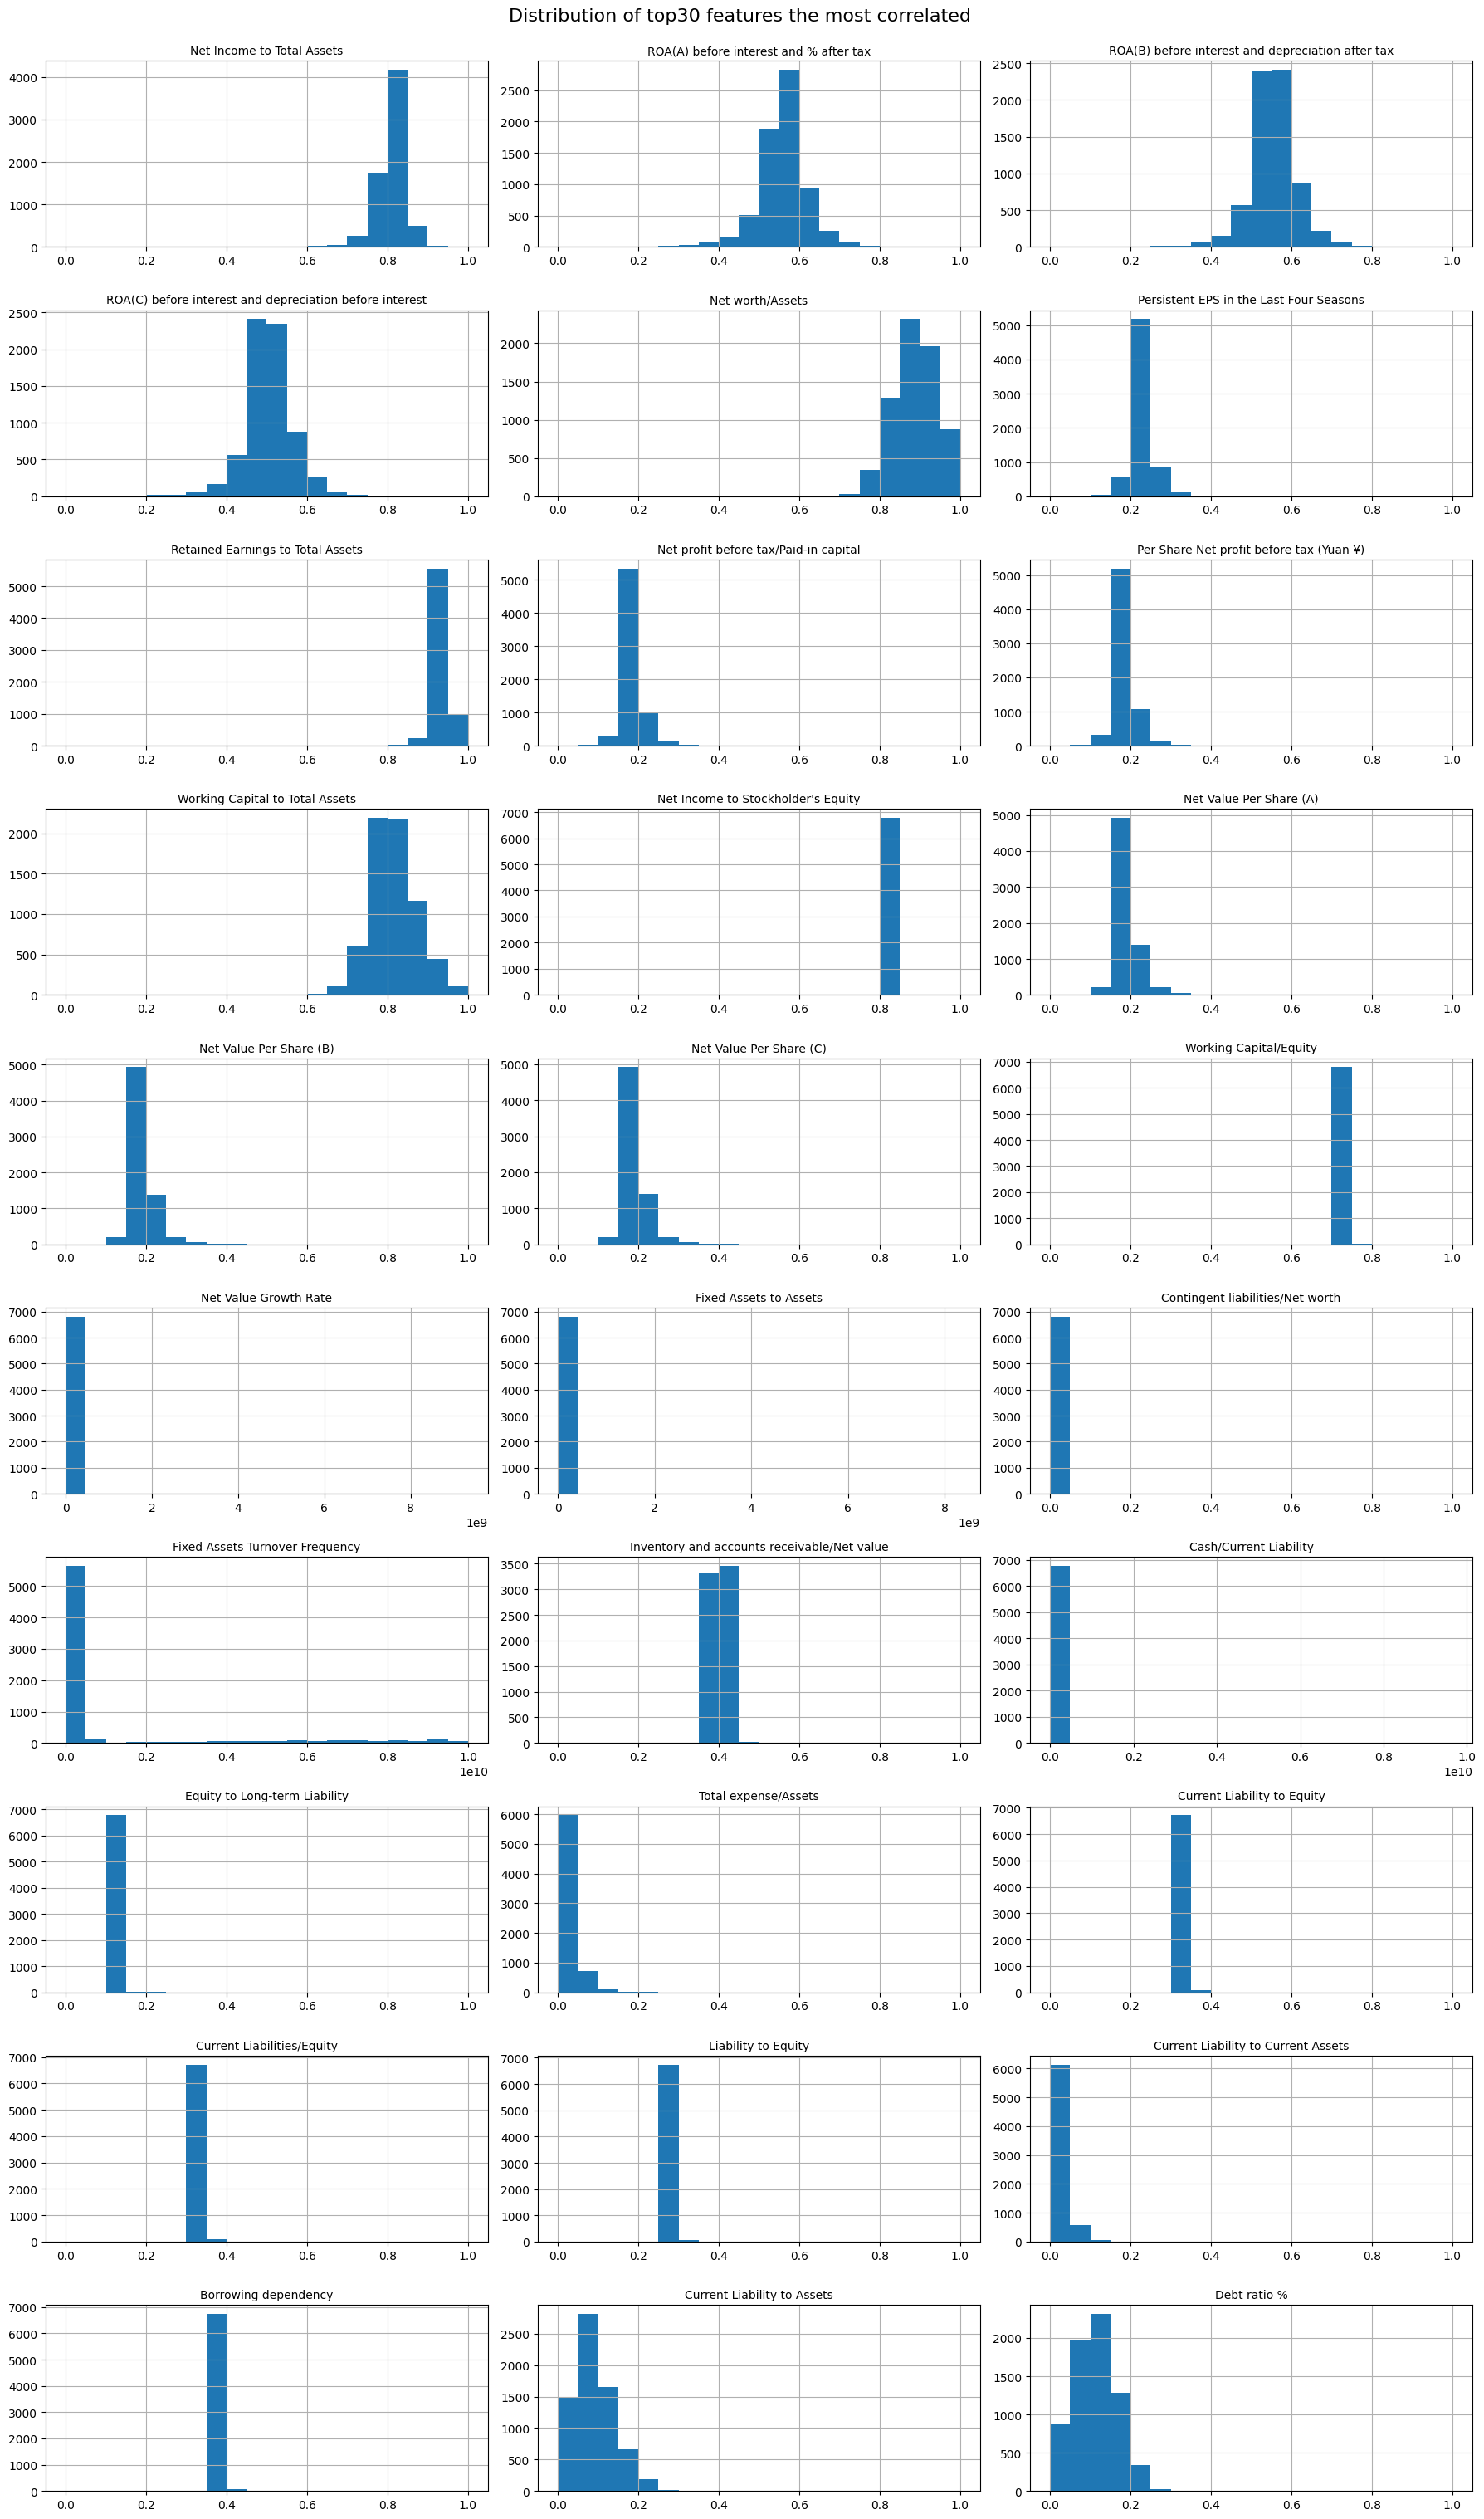

' \nfig_all, axes_all = plt.subplots(nrows=19, ncols=5, figsize=(30, 60))\n\naxes_all = axes_all.flatten()\n\nfor i, col in enumerate(FEATURE_COLS):\n    if col in df.columns:\n        df[col].hist(bins=30, ax=axes_all[i])\n        axes_all[i].set_title(col, fontsize=10) \n    else:\n        axes_all[i].set_title(f"\'{col}\' not find", fontsize=10)\n\nplt.tight_layout()\nplt.suptitle("Distribution of all features", y=1.01, fontsize=20)\nplt.show()\n'

In [5]:
print(df[FEATURE_COLS].describe().T)

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 30)) 

axes = axes.flatten()

for i, col in enumerate(top_30_features.index):
    if col in df.columns:
        df[col].hist(bins=20, ax=axes[i]) #axes0 at i=0
        axes[i].set_title(col, fontsize=10)
    else:
        axes[i].set_title(f"'{col}' not find", fontsize=10)

plt.tight_layout()
plt.suptitle("Distribution of top30 features the most correlated ", y=1.01, fontsize=16)
plt.show()

""" 
fig_all, axes_all = plt.subplots(nrows=19, ncols=5, figsize=(30, 60))

axes_all = axes_all.flatten()

for i, col in enumerate(FEATURE_COLS):
    if col in df.columns:
        df[col].hist(bins=30, ax=axes_all[i])
        axes_all[i].set_title(col, fontsize=10) 
    else:
        axes_all[i].set_title(f"'{col}' not find", fontsize=10)

plt.tight_layout()
plt.suptitle("Distribution of all features", y=1.01, fontsize=20)
plt.show()
"""

For the Bivariate Analysis, we will compare the distribution of these 30 features with compagnies which bankrupt and those who didn't. 

Same idea as before, only 30 otherwise it will be overload. Some visuals were unreadable as the values were really close to each others, this is why I put showfliers at False in order to zoom on these unreadable visuals. 

I also implemented a heatmap in order to find which features calculate the same things and are redundants (multi-colinearity problem). Annot parameter is at False as we don't want the values to be written in each box because it is not readable. Vmin and vmax are between -1 and 1 as a correlation is located in this range. 

Thus, we will mostly follow the same steps in the code as in the univariate analysis except that the visuals are differents. Note that in the first loop, we removed x-axis label (target labels) and y-axis label (feature labels). Thus, 0 will mean no bankrupt and 1 will mean bankrupt but we still have the title of the feature at the top

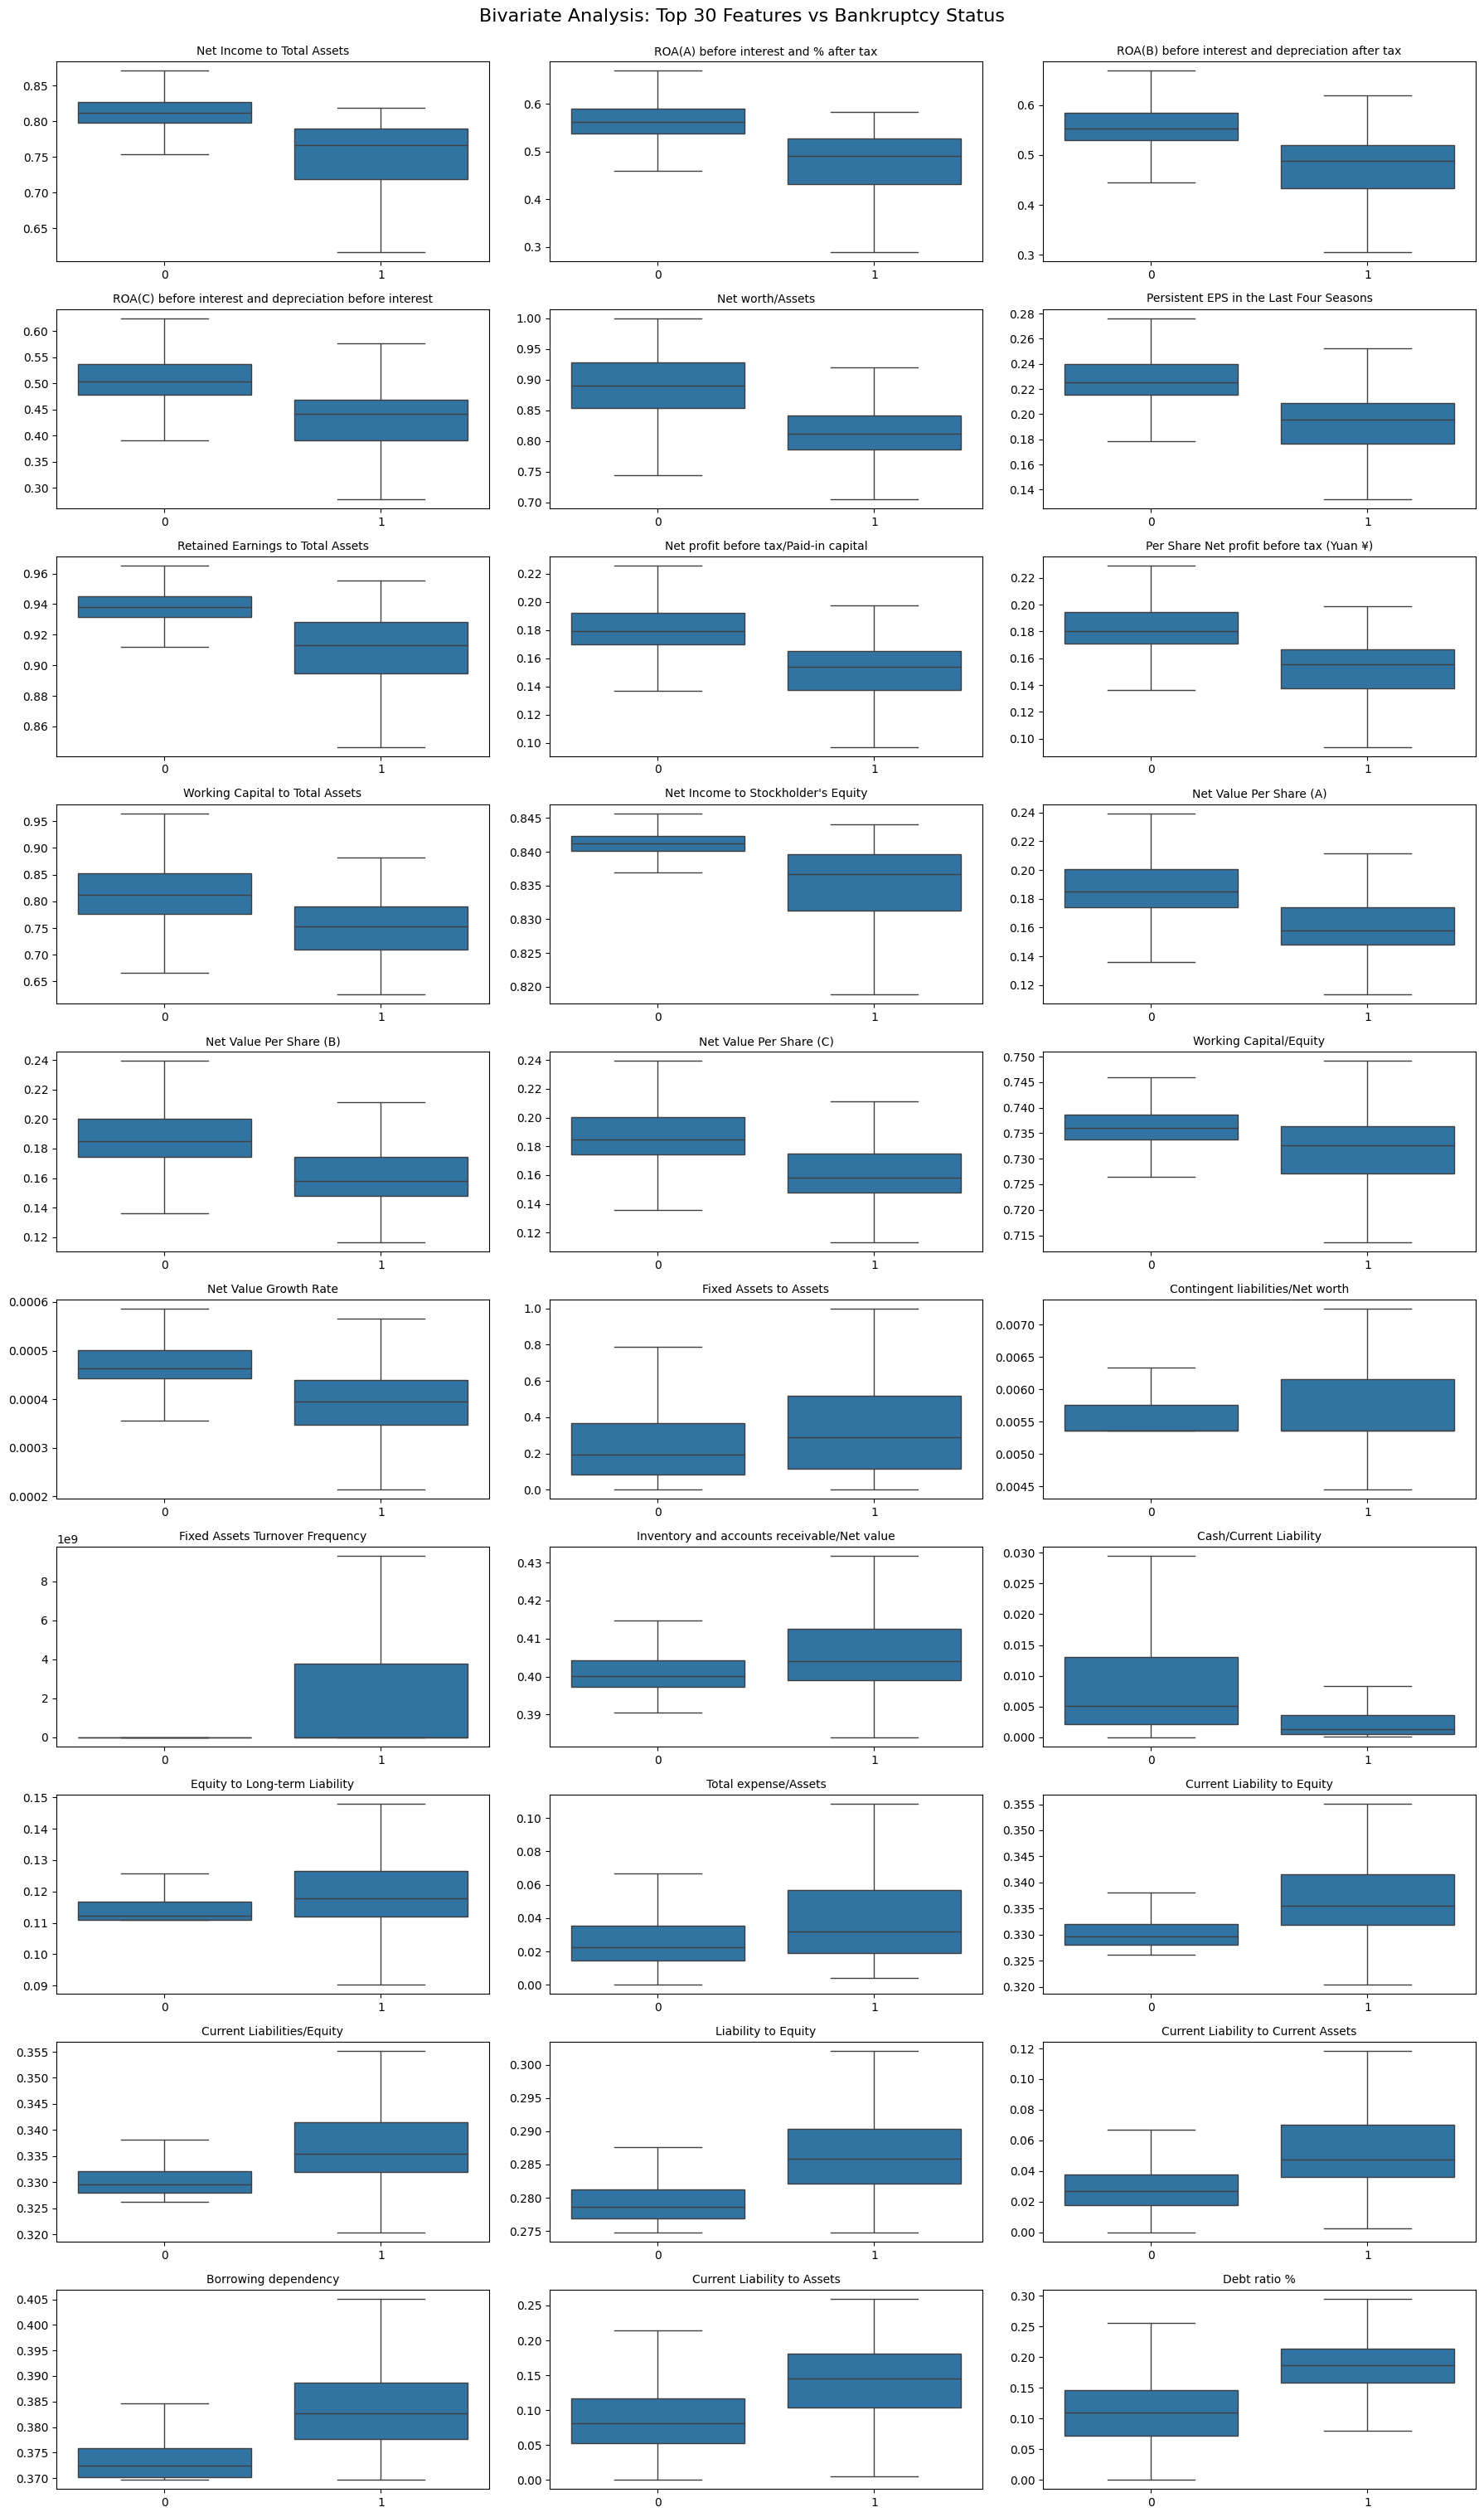

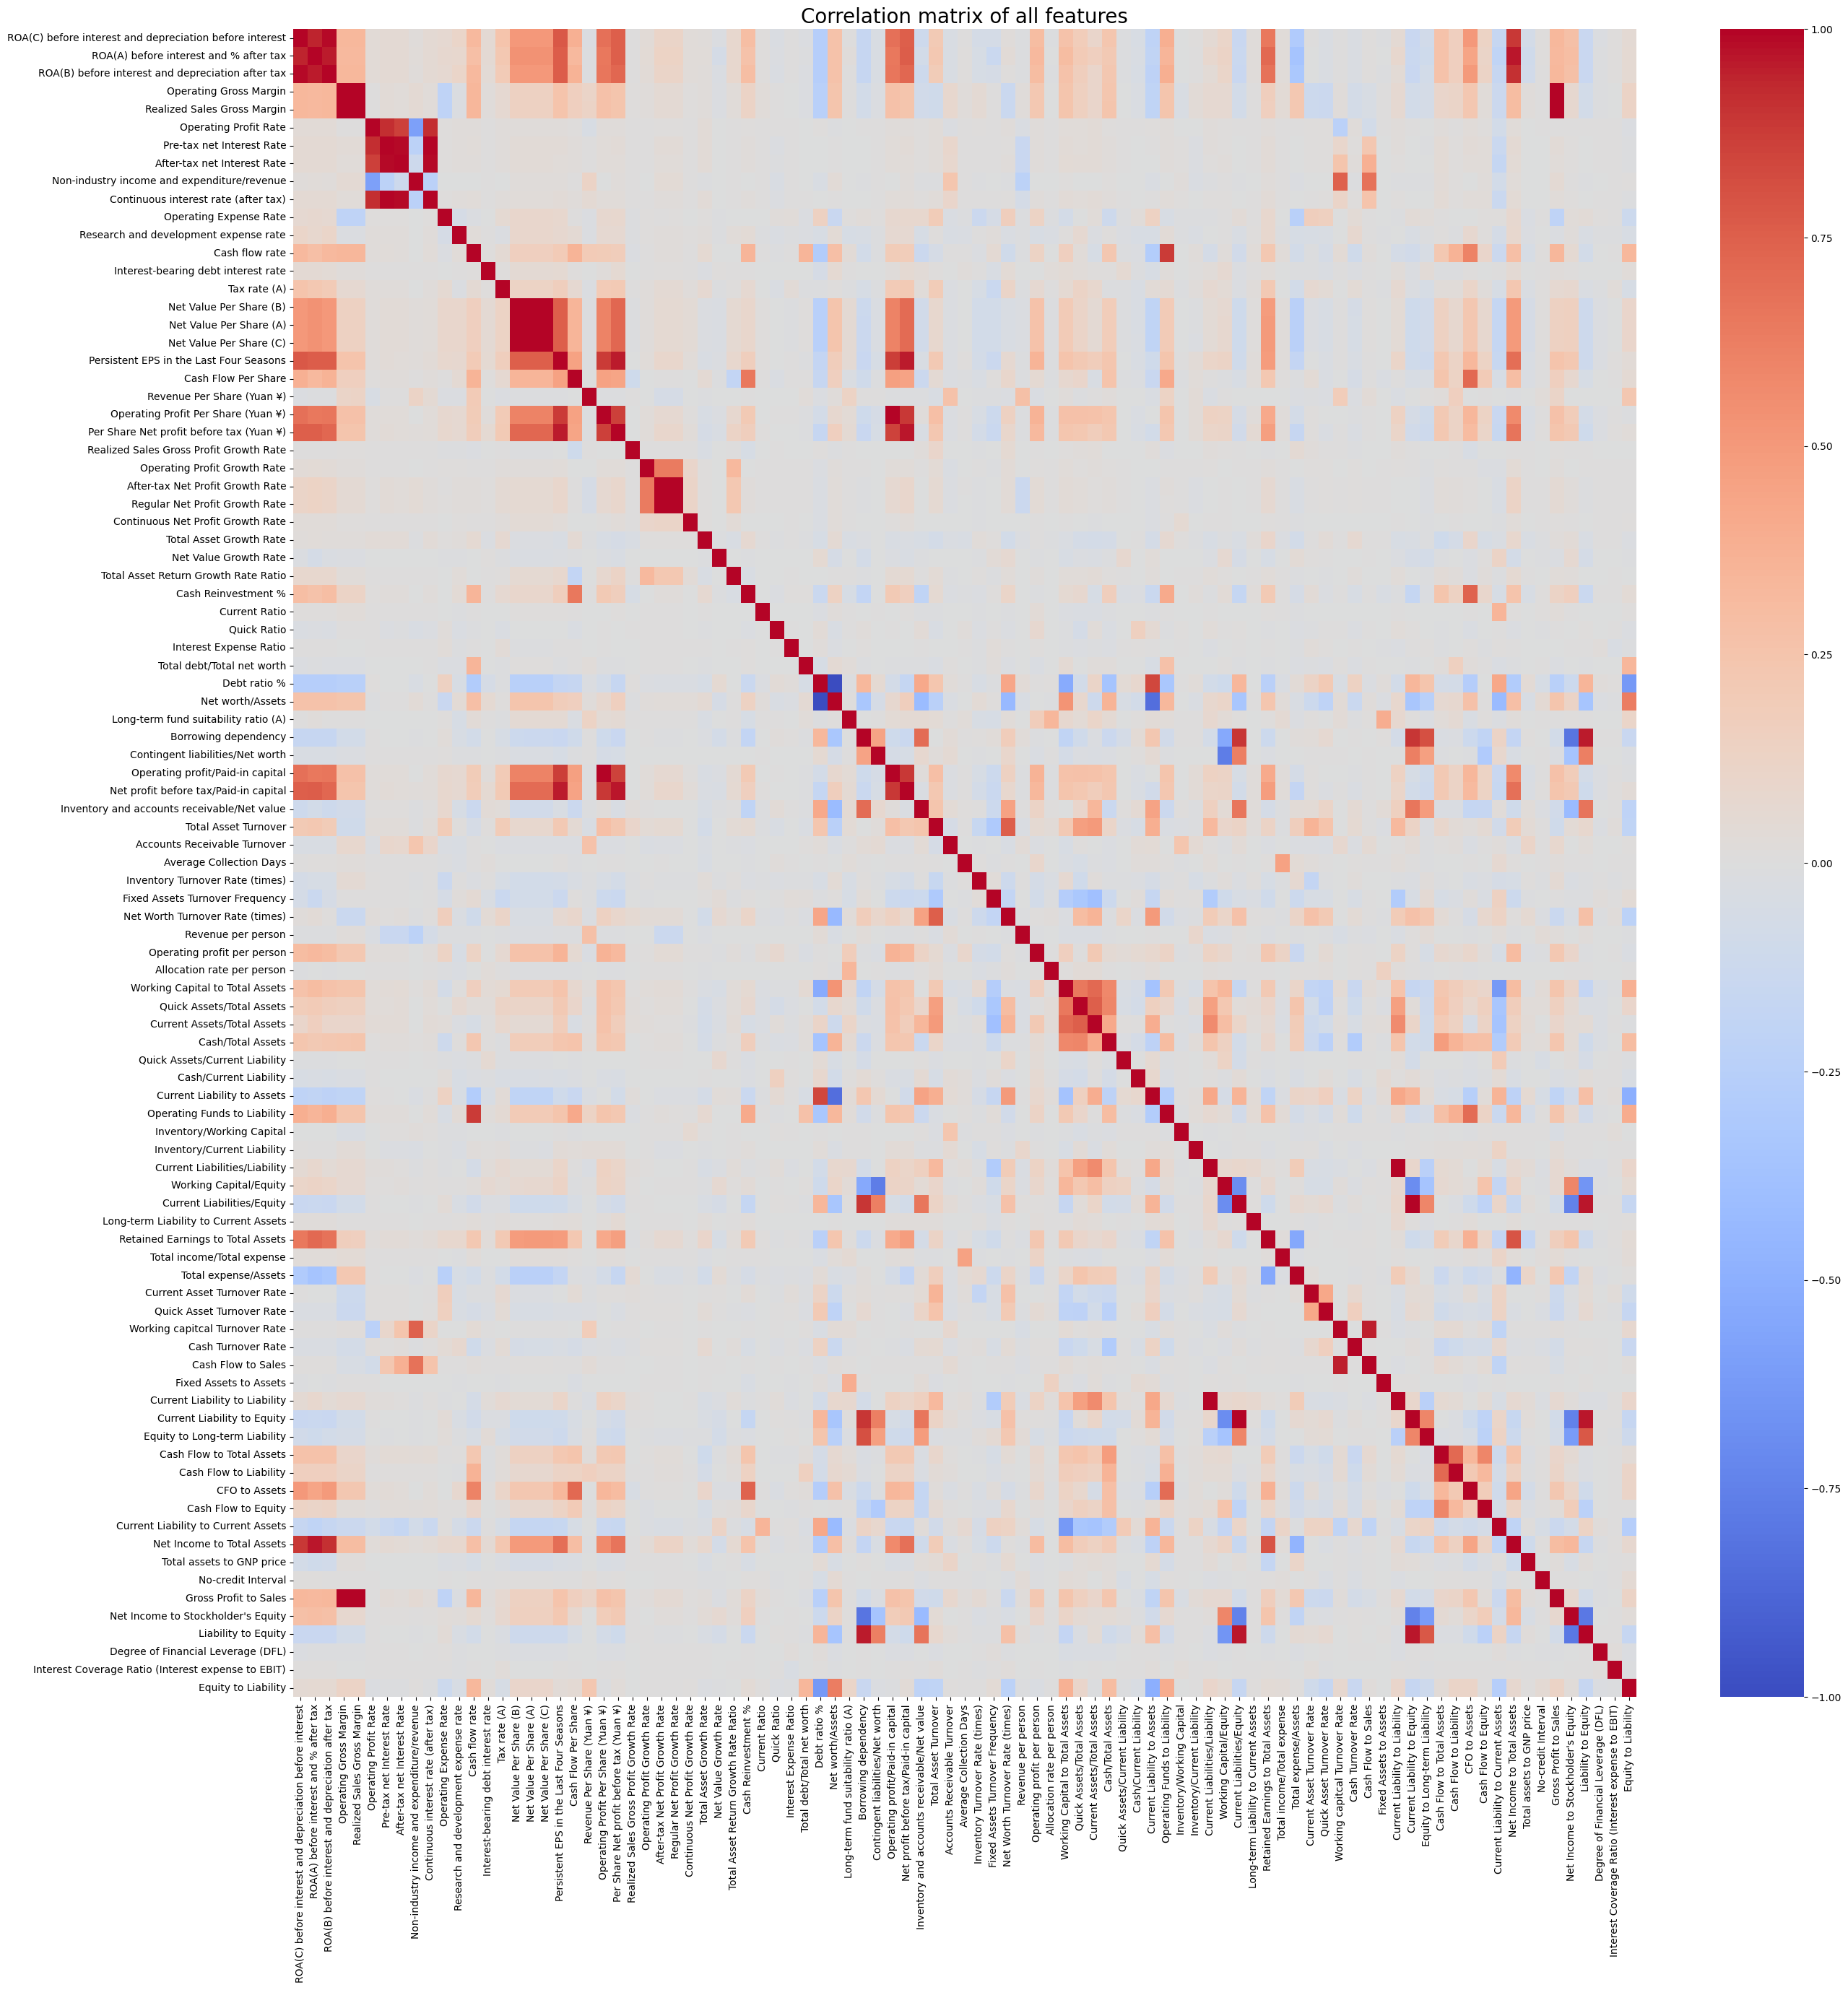

In [6]:
top_30_feature_list = top_30_features.index

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(18, 30)) 

axes = axes.flatten()

for i, col in enumerate(top_30_feature_list):
    
    current_ax = axes[i] # Get the current axis to plot on. Before, we implemented it directly in the df[col].hist
    
    if col in df.columns:
        sns.boxplot(x=TARGET_COL, y=col, data=df, ax=current_ax, showfliers=False)
        current_ax.set_title(col, fontsize=10)
        current_ax.set_xlabel('')
        current_ax.set_ylabel('') 
    else:
        current_ax.set_title(f"'{col}' not found", fontsize=10)


plt.tight_layout()
plt.suptitle("Bivariate Analysis: Top 30 Features vs Bankruptcy Status", y=1.01, fontsize=16)
plt.show()

corr_matrix = df[FEATURE_COLS].corr() # Pearson matrix

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix of all features", fontsize=20)
plt.show()

# Machine Learning Techniques

For this project, we will apply Classification and Clustering.

These choices are directly motivated by the structure of the dataset and the analytical goals. In the following lines, we may repeat what we said in the introduction of the descriptive analysis.

Task 1: Classification
This type of analysis is interesting because the dataset contains a clear, binary target variable (Bankrupt? = Yes or No). This makes it perfectly suited for a classification task. The objective is to build a predictive model that can accurately identify which companies are at high risk of bankruptcy based on their financial ratios.
I choose this method because we must choose classification as our goal is prediction and our target variable is categorical (0 or 1).

Task 2: Clustering
This type of analysis is interesting because the dataset features 95 financial ratios, providing a rich, high-dimensional space for unsupervised learning. The goal of clustering  is discovery. We aim to identify if naturally distinct "profiles" or "archetypes" of companies (e.g., 'stable low-risk', 'high-growth/high-debt', 'at-risk') exist within the data, based only on their financial features, not their bankruptcy status.
I choose this method because this complements classification. While classification predicts an outcome, clustering describes the hidden structure of the data, that allows us to define patterns/clusters.

Why not Regression ?
The choice to use Classification was mandatory and the most coherent. Our target variable (Bankrupt?) is binary, not a continuous numerical value. 
Indeed, the choice to exclude Regression was also mandatory. Regression models are designed to predict continuous values (e.g., a stock price or a housing price). Attempting to use regression for a binary outcome is inappropriate for this problem.
Therefore, Clustering was selected as the logical second method. It offers a completely different perspective on the data, fulfilling the project requirements.

Let's start by defining our train and test dataset. 

We can do so by splitting our dataset in two, but not naively. We're going to see that we only have 220 compagnies that 
actually bankrupt over 6819. It is widely disproportionate and we need to adress this issue in our train model otherwise our model will be wrong. Thus, one possiblity is to fill it with only 220 compagnies that didn't bankrupt and all which did bankrupt. In this case, we will have a perfectly balanced train dataset but that would be problematic for the test of the model. 

Indeed, we will test our model in a fully "clean" dataset of compagnies (that didn't bankrupted). In order to adress this other issue, we will split our dataset in 80% for train and 20% for test and we will use stratify=y in order to ensure that both train and test sets have the same 3.2% ratio of bankruptcies (maximum ratio with respect to our dataset) after the split. 

I also computed the first solution as comments. Note that we used random_state to ensure that we always have the same samples every time (=42 as a convention)

In [7]:
y = df[TARGET_COL]
X = df.drop(columns=TARGET_COL)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Total instances: {len(X)}")
print(f"Training instances: {len(X_train)}")
print(f"Test instances: {len(X_test)}")

print("\n--- Training set target distribution ---")
print(y_train.value_counts(normalize=True) * 100)
print(f"Nombre of bankrup in y_test : {sum(y_train == 1)}")


print("\n--- Test set target distribution ---")
print(y_test.value_counts(normalize=True) * 100)
print(f"Number of bankrupt in y_test: {sum(y_test == 1)}")

"""
from sklearn.utils import shuffle

df_bankrupt = df[df[TARGET_COL] == 1] # 220 instances
df_solvent = df[df[TARGET_COL] == 0]  # 6599 instances

print(f"Bankrupt instances: {len(df_bankrupt)}")
print(f"Solvent instances: {len(df_solvent)}")

df_solvent_sample = df_solvent.sample(n=220, random_state=42)

df_train = pd.concat([df_bankrupt, df_solvent_sample])

df_train = shuffle(df_train, random_state=42) #shuffle so the training set doesn't see all 1's and then all 0's as bankrupt value. This would lead to an error.

df_test = df.drop(df_train.index)

print(f"\nTraining set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

y_train = df_train[TARGET_COL]
X_train = df_train.drop(columns=TARGET_COL)

y_test = df_test[TARGET_COL]
X_test = df_test.drop(columns=TARGET_COL)

print(f"\nTraining data (y_train) distribution:\n{y_train.value_counts()}")
print(f"\nTest data (y_test) distribution:\n{y_test.value_counts()}")
"""

Total instances: 6819
Training instances: 5455
Test instances: 1364

--- Training set target distribution ---
Bankrupt?
0    96.773602
1     3.226398
Name: proportion, dtype: float64
Nombre of bankrup in y_test : 176

--- Test set target distribution ---
Bankrupt?
0    96.774194
1     3.225806
Name: proportion, dtype: float64
Number of bankrupt in y_test: 44


'\nfrom sklearn.utils import shuffle\n\ndf_bankrupt = df[df[TARGET_COL] == 1] # 220 instances\ndf_solvent = df[df[TARGET_COL] == 0]  # 6599 instances\n\nprint(f"Bankrupt instances: {len(df_bankrupt)}")\nprint(f"Solvent instances: {len(df_solvent)}")\n\ndf_solvent_sample = df_solvent.sample(n=220, random_state=42)\n\ndf_train = pd.concat([df_bankrupt, df_solvent_sample])\n\ndf_train = shuffle(df_train, random_state=42) #shuffle so the training set doesn\'t see all 1\'s and then all 0\'s as bankrupt value. This would lead to an error.\n\ndf_test = df.drop(df_train.index)\n\nprint(f"\nTraining set shape: {df_train.shape}")\nprint(f"Test set shape: {df_test.shape}")\n\ny_train = df_train[TARGET_COL]\nX_train = df_train.drop(columns=TARGET_COL)\n\ny_test = df_test[TARGET_COL]\nX_test = df_test.drop(columns=TARGET_COL)\n\nprint(f"\nTraining data (y_train) distribution:\n{y_train.value_counts()}")\nprint(f"\nTest data (y_test) distribution:\n{y_test.value_counts()}")\n'

We need to standardise our datas because they don't have the same scale and this will be an issue for the differents techniques we're going to use in order to train our model. 

We will make the scaler analyse our data (find the mean and the standard deviation) and transform each values of X_train (minus the mean and divide by the standard deviation). We do this in order to have all values at the same scale (= to avoid imbalance of features). 

For the scaler appplication on test datas, we don't use .fit (= we don't make our scaler analyse these datas) as they are the test datas.

We know that we have a lot of features and, based on the previous heatmap, some features may appears redondant (multicollinearity).

To address this, we performed a supplementary step using Lasso Regression.

The algorithm successfully eliminated 35 features (setting their coefficients to exactly zero), retaining only 58 critical variables out of the original 94. This confirms our hypothesis that the dataset contained significant redundancy and multicollinearity (e.g., multiple variations of the same financial ratio).

We also found useful to know which features were the strongest predictor so we computed an output to showcase this.

Persistent EPS in the Last Four Seasons (Coeff: -0.98) is the strongest predictor. This indicates that consistent, long-term earnings per share is the best shield against bankruptcy.
Equity to Liability (Coeff: -0.95) and Net Income to Total Assets (Coeff: -0.93) follow closely. This perfectly aligns with financial theory: companies with low leverage (high equity vs. liability) and high asset profitability are structurally safe.

In the other hand, Total debt/Total net worth (Coeff: +0.59) and Borrowing dependency (Coeff: +0.54) appear as top positive coefficients. As expected, these are the primary warning signs: higher reliance on debt directly increases the probability of bankruptcy.

The Lasso analysis reveals that solvency is primarily predicted by a company's ability to generate consistent earnings (EPS) and maintain a strong equity cushion, rather than just short-term cash flows.

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print(f"Shape of scaled X_train: {X_train_scaled.shape}")
print(f"Shape of scaled X_train: {X_test_scaled.shape}")

print("\n--- Training of Lasso for selection ---")
lasso_selector = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42, max_iter=1000)
lasso_selector.fit(X_train_scaled, y_train)

coefs = lasso_selector.coef_.flatten()

selection_mask = coefs != 0

selected_features_names = X_train.columns[selection_mask]
print(f"Lasso kept {sum(selection_mask)} features on {len(selection_mask)}.")
print(f"Deleted Features : {len(selection_mask) - sum(selection_mask)}")

print("\n--- Dataset reduction ---")
X_train_reduced = X_train_scaled[:, selection_mask]
X_test_reduced = X_test_scaled[:, selection_mask]

print(f"New shape Train : {X_train_reduced.shape}")
print(f"New shape Test  : {X_test_reduced.shape}")

lasso_results = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefs, 'Abs_Coefficient': np.abs(coefs)})

print("\n--- Top 10 Most Critical Features (Selected by Lasso) ---")
print(lasso_results.sort_values(by='Abs_Coefficient', ascending=False).head(10))

Shape of scaled X_train: (5455, 93)
Shape of scaled X_train: (1364, 93)

--- Training of Lasso for selection ---
Lasso kept 58 features on 93.
Deleted Features : 35

--- Dataset reduction ---
New shape Train : (5455, 58)
New shape Test  : (1364, 58)

--- Top 10 Most Critical Features (Selected by Lasso) ---
                                    Feature  Coefficient  Abs_Coefficient
18  Persistent EPS in the Last Four Seasons    -0.981744         0.981744
92                      Equity to Liability    -0.954017         0.954017
84               Net Income to Total Assets    -0.932112         0.932112
32                            Current Ratio    -0.873294         0.873294
41         Operating profit/Paid-in capital     0.599528         0.599528
35               Total debt/Total net worth     0.587686         0.587686
39                     Borrowing dependency     0.540760         0.540760
15                  Net Value Per Share (B)    -0.517532         0.517532
12                       

Now let's train our model on the logistic regression and show some visuals of it's performance. 

We increase max_iter to 1000 in order to avoid ConvergenceWarning as our dataset has still a lot of features. We will make predictions on the test set.

We used target_names in order to make the report clearer (instead of 0 and 1) in the classification_report parameters. In ConfusionMatrixDisplay and RocCurveDisplay, we don't need y_pred_log as parameters as these metrics commands will do it automaticaly. We also used RocAucCurve for visuals as the plot displayed is excellent for showing model performance on imbalanced data. A score of 0.5 is random guessing, 1.0 is perfect


Classification Report:
              precision    recall  f1-score   support

 Solvent (0)       0.97      0.99      0.98      1320
Bankrupt (1)       0.38      0.18      0.25        44

    accuracy                           0.96      1364
   macro avg       0.68      0.59      0.61      1364
weighted avg       0.95      0.96      0.96      1364


Confusion Matrix


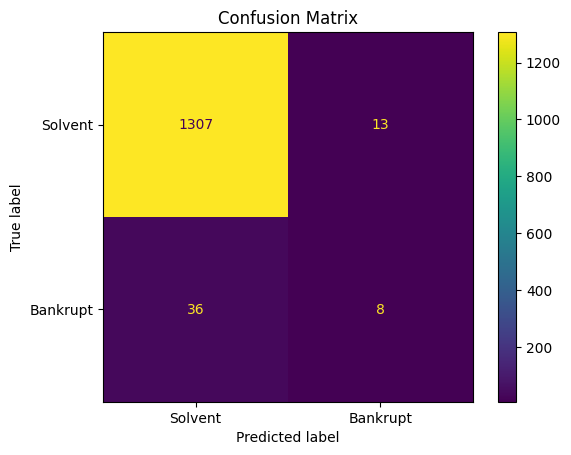


ROC-AUC Curve


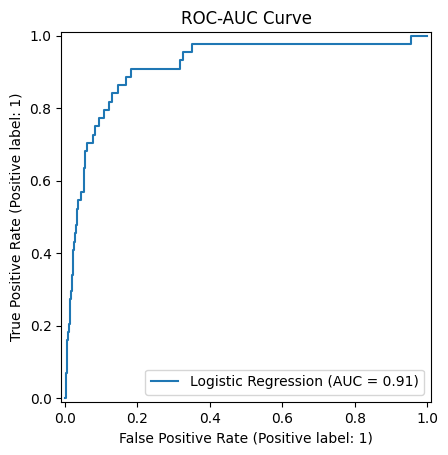

In [9]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)

log_reg.fit(X_train_reduced, y_train)

y_pred_log = log_reg.predict(X_test_reduced)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['Solvent (0)', 'Bankrupt (1)'])) 

print("\nConfusion Matrix")
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_reduced, y_test, display_labels=['Solvent', 'Bankrupt'])
plt.title("Confusion Matrix")
plt.show()

print("\nROC-AUC Curve")
RocCurveDisplay.from_estimator(log_reg, X_test_reduced, y_test, name='Logistic Regression')
plt.title("ROC-AUC Curve")
plt.show()

To robustly evaluate the stability of our model after Lasso feature selection, we performed a 5-fold Cross-Validation using the reduced dataset (X_train_reduced).

The cross_val_score function splits the training data into 5 folds. It automatically applies stratification, ensuring that the minority class (bankrupt companies) is represented proportionally in every fold without needing manual specification.
We utilized scoring='roc_auc' as our evaluation metric. Given the dataset's severe imbalance, standard accuracy would be misleading. ROC-AUC provides a trustworthy measure of the model's discriminative ability.

In [10]:
cv_scores = cross_val_score(log_reg, X_train_reduced,y_train, cv=5, scoring='roc_auc'
)

print(f"\nCross-Validation ROC-AUC Scores (5 Folds): {cv_scores}")
print(f"Mean CV ROC-AUC Score: {cv_scores.mean():.4f}")
print(f"Std Dev CV ROC-AUC Score: {cv_scores.std():.4f}")


Cross-Validation ROC-AUC Scores (5 Folds): [0.90332792 0.94364177 0.86555736 0.92748918 0.91108478]
Mean CV ROC-AUC Score: 0.9102
Std Dev CV ROC-AUC Score: 0.0263


The Logistic Regression model demonstrated strong stability and predictive potential, evidenced by a mean Cross-Validation ROC-AUC of 0.9102 and a consistent Test ROC-AUC of 0.91. While the overall Accuracy appears high at 96%, this metric is heavily skewed by the majority 'Solvent' class. A deeper look at the critical 'Bankrupt' class reveals that the model is operationally conservative at the default decision threshold: it achieved a Precision of 0.38 (one in three bankruptcy alerts was correct) and a low Recall of 0.18 (identifying only 18% of actual bankruptcies), resulting in a F1-Score of 0.25. This contrast between the excellent AUC (0.91) and the low Recall (0.18) proves that the model effectively ranks risky companies higher than healthy ones, but the standard 50% probability threshold is too strict to capture the majority of bankruptcy cases in a real-world setting.

Also, as we say before, while the Weighted Average F1-score of 0.96 might suggest near-perfect performance, it is heavily biased by the majority class. The Macro Average F1-score of 0.61 offers a more honest assessment, reflecting the disparity between the model's excellent detection of healthy companies and its struggle to recall bankruptcies. Furthermore, the low Cross-Validation Standard Deviation (0.0263) is a critical indicator of success, proving that despite the recall challenges, the model's stability and ranking ability (AUC) are robust and reliable.

To fulfill the project's requirement of applying a second machine learning technique, we will now perform Clustering.

We will use the K-Means algorithm to analyze all 94 financial features to see if the data naturally separates into distinct 'profiles' or groups of companies based on their financial characteristics, independent of the bankruptcy label. It is worth noting that the feature selection performed by Lasso could also be beneficial here: running K-Means on the reduced set of critical features would likely minimize noise and produce even more distinct financial profiles. However, We decided to perform the clustering analysis on the full set of 94 features. Since Lasso is a supervised technique that filters variables based on their direct relationship with the target (Bankrupt?), using it here would have biased our exploratory analysis solely towards risk factors.

The first step in K-Means clustering is to determine the optimal number of clusters (K). We used the Elbow Method for this analysis.

Because K-Means is a distance-based algorithm, we first scaled the entire dataset (unlike in the logistic regression) as, for clustering, there's no 'test' set, using StandardScaler to ensure all features are weighted equally. We then ran the K-Means algorithm for K-values 2 through 10 (only to 10 because more might not be relevant and it is very unlikely that we have more than 10 clusters). For each run, we recorded the model's inertia metric (using property inertia_) measuring how compact/tight the clusters are. By plotting this inertia against the K-values, we can look for the "elbow" point, which represents the optimal K where adding more clusters no longer provides a significant improvement. 

Also, we set n_init=10 to avoid "false start" because of a misleading first random point. 

Completed K=2
Completed K=3
Completed K=4
Completed K=5
Completed K=6
Completed K=7
Completed K=8
Completed K=9
Completed K=10


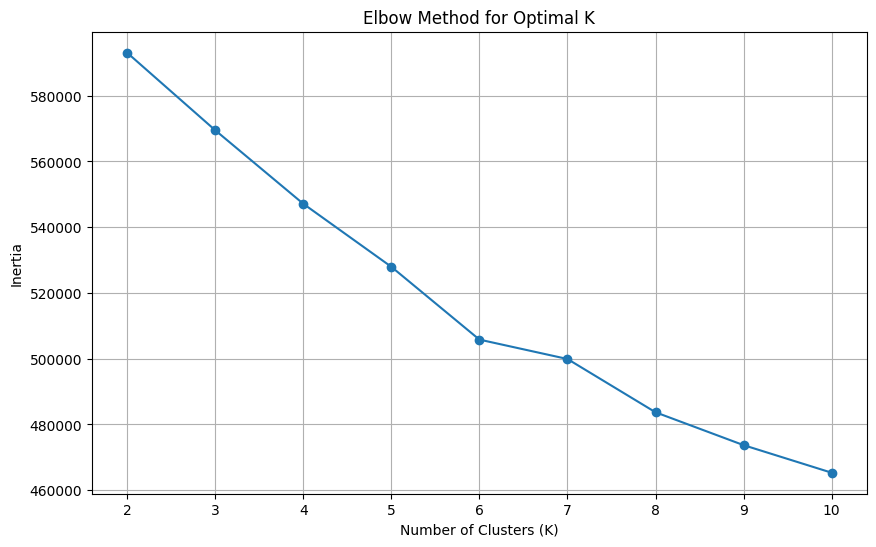

In [11]:
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X)

inertia_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_full)
    
    inertia_scores.append(kmeans.inertia_)
    print(f"Completed K={k}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_scores, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Based on previous results, we can clearly consider that an optimal elbow is 6 as the curve seems to flattens above this point especially from 6 to 7 clusters. 

We will thus use the value of cluster for our model. We used labels_ in order to asign each compagny a cluster, we will then have an array where each items is the cluster number (0-5) for the corresponding compagny. After this, we created a copy of our original X dataset (without bankruptcy, not scaled), and add to the copy a column 'cluster'. This step is essential for the subsequent analysis, allowing us to profile the companies within each cluster.

In [12]:
OPTIMAL_K = 6

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans.fit(X_scaled_full)

cluster_labels = kmeans.labels_ 

X_with_clusters = X.copy()
X_with_clusters['Cluster'] = cluster_labels

print(X_with_clusters.head())

   ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                   

Let's dive to the cluster analysis, the most important part of clustering. We will find the "average profile" for each of the 6 clusters.

We will group the data by cluster and calculate the mean of some of the most important financial ratios (based on our Top 30 we used for univariate and bivariate analysis) by using groupby('Cluster').mean (Cluster which is the new column we add before). We will have a new table with rows which are our 6 clusters (0-5), and the columns are all 94 features. Each cell will then shows the average value of that specific feature for that specific cluster. I decided to only display half of the most negatives correlated features and half of the most positive correlated features for each cluster as we don't want to have unreadable output and not useful information

We used .union() because we are combining Index objects (the lists of column names), not DataFrames, using pd.concat() as we did before would be incorrect here, as it's designed to stick entire DataFrames together, not to combine lists of names.

As a final analysis, we re-introduced the original Bankrupt? label to set X_with_clusters in order to calculate the average bankruptcy rate within each cluster, allowing us to see if our unsupervised model successfully isolated the high-risk companies.

In [13]:
top_7_neg = top_15_neg_features.head(7).index

top_7_pos = top_15_pos_features.tail(7).index

features_to_analyze_14 = top_7_neg.union(top_7_pos)

cluster_profiles = X_with_clusters.groupby('Cluster').mean()

print(cluster_profiles[features_to_analyze_14].T)

if 'Bankrupt' not in X_with_clusters.columns:
    X_with_clusters['Bankrupt'] = y

cluster_bankruptcy_rates = X_with_clusters.groupby('Cluster')['Bankrupt'].mean() * 100

print("\n--- Bankruptcy Rate (%) per Cluster ---")
print(cluster_bankruptcy_rates.sort_values(ascending = False))

Cluster                                                    0         1  \
Borrowing dependency                                0.370570  0.376234   
Current Liabilities/Equity                          0.328804  0.335174   
Current Liability to Assets                         0.064569  0.141269   
Current Liability to Current Assets                 0.017206  0.032390   
Current Liability to Equity                         0.328804  0.335174   
Debt ratio %                                        0.071527  0.152939   
Liability to Equity                                 0.277285  0.283053   
Net Income to Total Assets                          0.850563  0.812951   
Net worth/Assets                                    0.928473  0.847061   
Persistent EPS in the Last Four Seasons             0.270486  0.232070   
ROA(A) before interest and % after tax              0.638694  0.566788   
ROA(B) before interest and depreciation after tax   0.630791  0.555116   
ROA(C) before interest and depreciatio

The analysis of the cluster means shows clear "personalities." For example, Clusters 0 and 2 appear to be the 'Healthy' profiles, characterized by very low Debt ratio % (0.07% and 0.05%) and the highest Net worth/Assets (0.92 and 0.95). In contrast, Cluster 3 is a clear outlier, showing significantly higher debt (Debt ratio %: 0.29) and lower profitability (ROA(A): 0.35) than the others groups.

The most critical finding comes from the bankruptcy rate analysis. This confirms our profiling:

Cluster 3 (The 'High-Risk' Profile): This group, which the model identified based on for example its high-debt profile, has a 75% bankruptcy rate.

Cluster 5 (The 'At-Risk' Profile): This group shows a moderately high 15.44% bankruptcy rate.

Clusters 0 & 2 (The 'Healthy' Profiles): These groups had a 0% bankruptcy rate. We can clearly also include clusters 4 and 1 in this group

This result is a major success. It proves that the unsupervised K-Means model was able to successfully isolate the high-risk companies from the healthy ones using only their financial data, and without ever seeing the Bankrupt? label during its training.

In hindsight, after seeing these results, we can see that a simpler model with K=3 (which was also a visible 'elbow') might have been a viable alternative. It would likely have captured the three main risk profiles: a "High-Risk" group (our Cluster 3), an "At-Risk" group (our Cluster 5), and one large "Healthy" group (combining our other clusters). However, our choice of K=6 provided a more granular and detailed view of the healthy population.

In conclusion, these results are highly conclusive. Both models proved to be stable and insightful, generating actionable value from complex financial data. The clustering successfully isolated risk profiles, while the classification demonstrated strong predictive stability despite the challenges of the severe class imbalance.

## Final Conclusion and Acknowledgements
Thank you for taking the time to read this report. I thoroughly enjoyed working on this project and found it to be an incredibly enriching experience. The entire process, from data cleaning to interpretation, has strongly motivated me to continue pursuing this type of analysis in the future.

While both models were insightful, I found the clustering task to be particularly fascinating. I believe the outputs from unsupervised learning, which reveal hidden structures and natural profiles within the data, are exceptionally valuable.

This project was completed as part of my Data mining & Machine Learning course at EDHEC Business School. I would like to extend my gratitude to our professor, Mr. Christophe Desagre, who not only taught us these models but also provided guidance and support throughout this project.